**Machine Learning for MD Data:** Learning Reaction Coordinates 

BIT25 Conference in Toruń

- Analyzing large volumes of high-dimensional data requires dimensionality reduction: finding meaningful low-dimensional structures hidden in their high-dimensional observations.
- An example of such practice is the analysis of atomistic simulations, which characterize properties of high-dimensional dynamical systems.

R. Coifman:

*There is some inate truth in the low-dimensional manifold of the data and we would like to have a characterization of some latent variable which describes intrinsicly the changes of states.*

Source: https://www.youtube.com/watch?v=v4Ay31mwQi8

Properties of reaction coordinates:

<img src="https://github.com/jakryd/bit25-workshop/blob/main/fig/fig-potential-metastable.png?raw=true" width="600" style="margin-left:auto; margin-right:auto"/>

In [30]:
import numpy as np
import pandas as pd
import torch

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

We will work on a standard model system -- alanine dipeptide in vacuum:

<img src="https://raw.githubusercontent.com/CCPBioSim/biosimspace-advanced-simulation/de3f65372b49879b788f46618e0bfef78b2559b9/metadynamics/assets/alanine_dipeptide.png" width="600" style="margin-left:auto; margin-right:auto"/>

Download the data.

Features are pairwise distances between heavy atoms.

In [31]:
from urllib.request import urlretrieve

urlretrieve(
    url="https://zenodo.org/records/15756290/files/adp-feat-dist.data",
    filename="adp-feat-dist.data"
)

('adp-feat-dist.data', <http.client.HTTPMessage at 0x167972180>)

In [32]:
df = pd.read_csv(
    "adp-feat-dist.data",
    sep=" ",
    header='infer',
)

In [33]:
df

,time,energy,phi,psi,theta,d1,d2,d3,d4,d5,...,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45
0,0.00000,-42.867706,1.158887,-0.062493,-0.277660,0.151452,0.237371,0.241628,0.383889,0.438788,...,0.260934,0.305422,0.366489,0.501006,0.121898,0.136494,0.250460,0.227093,0.286349,0.147188
1,1.00000,-35.747223,1.111219,-0.603696,-0.070774,0.145782,0.232463,0.236251,0.380054,0.461041,...,0.257523,0.315515,0.347293,0.479157,0.123973,0.134938,0.251096,0.225544,0.284159,0.148281
2,2.00000,-22.255646,0.728072,-1.035362,0.393789,0.149086,0.234911,0.242539,0.385714,0.469854,...,0.255473,0.338352,0.313939,0.450488,0.124880,0.131097,0.246643,0.224512,0.283784,0.146184
3,3.00000,-20.344574,1.012503,-1.157839,0.017878,0.148510,0.229417,0.243333,0.384160,0.450256,...,0.252170,0.340675,0.311837,0.434864,0.121096,0.133588,0.244186,0.221912,0.277109,0.145273
4,4.00000,-37.787170,1.159205,-0.683593,0.131954,0.152158,0.239642,0.243398,0.383222,0.466896,...,0.251922,0.321590,0.334942,0.470411,0.122082,0.137745,0.248524,0.224815,0.276933,0.146423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,99996.00475,-11.464264,-1.505169,1.366675,0.151529,0.153057,0.239632,0.247946,0.380080,0.468442,...,0.272386,0.315935,0.383613,0.508001,0.123420,0.131220,0.240852,0.219504,0.271484,0.141353
99997,99997.00475,-37.434723,-1.337126,1.426750,0.041038,0.148606,0.227268,0.249542,0.381025,0.482689,...,0.260634,0.292557,0.380055,0.511719,0.125808,0.135531,0.254852,0.228551,0.297417,0.144129
99998,99998.00475,-22.145233,-1.221497,1.162527,-0.217557,0.152255,0.239520,0.248578,0.384120,0.485045,...,0.252325,0.281011,0.370508,0.489832,0.127194,0.130361,0.238674,0.224148,0.275099,0.139155
99999,99999.00475,-19.024841,-1.327862,1.156643,-0.144797,0.156591,0.245586,0.248929,0.390534,0.487549,...,0.253759,0.273313,0.372044,0.498764,0.128671,0.132500,0.245185,0.234889,0.292515,0.146569


Let's look at the dihedral angles.

Phi is slow!

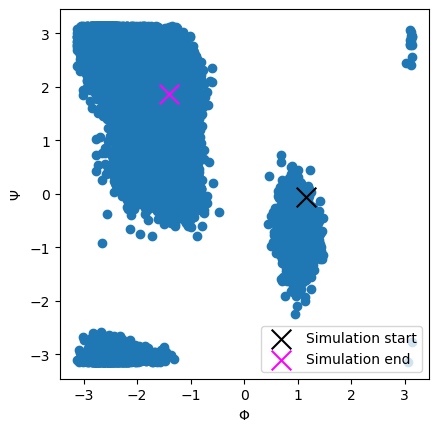

In [34]:
fig, ax = plt.subplots(1, 1)

ax.scatter(df["phi"], df["psi"])
ax.scatter(df["phi"][0], df["psi"][0], label="Simulation start", marker="x", c='k', s=200)
ax.scatter(df["phi"].values[-1], df["psi"].values[-1], label="Simulation end", marker="x", c='magenta', s=200)
ax.set_xlabel(r"$\Phi$")
ax.set_ylabel(r"$\Psi$")
ax.set_aspect('equal')
plt.legend()

Also the time series of the angles show this:

Text(0, 0.5, '$\\Psi$')

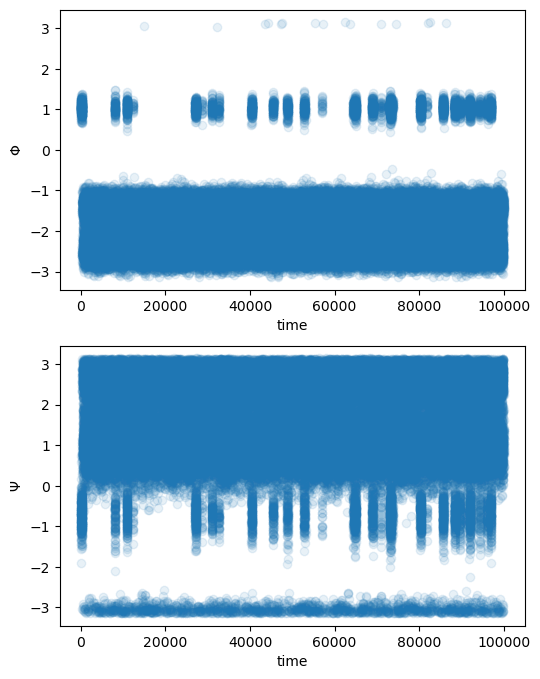

In [35]:
fig, ax = plt.subplots(2, 1, figsize=(6, 2 * 4))

ax[0].scatter(df["time"], df["phi"], alpha=0.1)
ax[0].set_xlabel(r"time")
ax[0].set_ylabel(r"$\Phi$")

ax[1].scatter(df["time"], df["psi"], alpha=0.1)
ax[1].set_xlabel(r"time")
ax[1].set_ylabel(r"$\Psi$")

How many states are there? 

Let's look at the density:

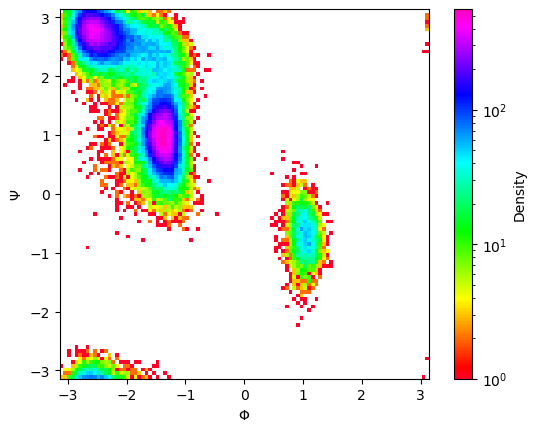

In [36]:
fig, ax = plt.subplots(1, 1)

handle = ax.hist2d(df["phi"], df["psi"], bins=100, cmap=plt.cm.gist_rainbow, norm=matplotlib.colors.LogNorm());
plt.colorbar(handle[-1], ax=ax, label="Density")

ax.set_xlabel(r"$\Phi$")
ax.set_ylabel(r"$\Psi$")
ax.set_aspect('equal')

Problems with clusterization when the coordinates are periodic:

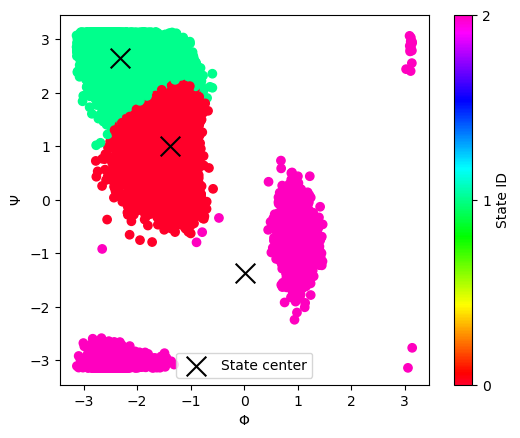

In [37]:
from sklearn.mixture import GaussianMixture

n_components = 3

gm = GaussianMixture(n_components=n_components, max_iter=1000)
labels = gm.fit_predict(df[["phi", "psi"]])

fig, ax = plt.subplots(1, 1)

handle = ax.scatter(df["phi"], df["psi"], c=labels, cmap=plt.cm.gist_rainbow)
plt.colorbar(handle, ax=ax, ticks=range(n_components), label="State ID")

ax.scatter(gm.means_[:, 0], gm.means_[:, 1], marker='x', c='k', s=200, label="State center")

ax.set_xlabel(r"$\Phi$")
ax.set_ylabel(r"$\Psi$")
ax.set_aspect('equal')
ax.legend()

Transform the coordinates into sines and cosines:

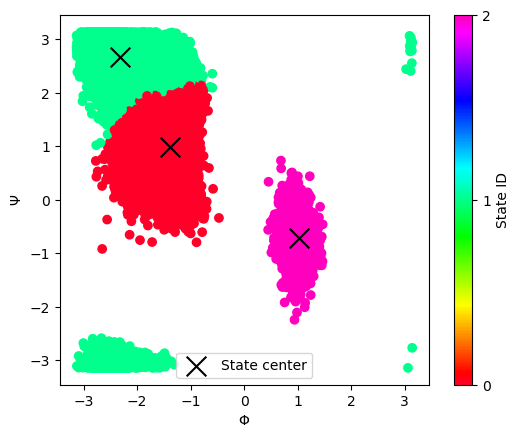

In [38]:
gm = GaussianMixture(n_components=3, max_iter=1000)

sin_cos = np.concat([np.sin(df[["phi", "psi"]]), np.cos(df[["phi", "psi"]])], axis=1)

labels = gm.fit_predict(sin_cos)

fig, ax = plt.subplots(1, 1)

handle = ax.scatter(df["phi"], df["psi"], c=labels, cmap=plt.cm.gist_rainbow)
plt.colorbar(handle, ax=ax, ticks=range(n_components), label="State ID")

means_phi = np.arctan2(gm.means_[:, 0], gm.means_[:, 2])
means_psi = np.arctan2(gm.means_[:, 1], gm.means_[:, 3])

ax.scatter(means_phi, means_psi,  marker='x', c='k', s=200, label="State center")

ax.set_xlabel(r"$\Phi$")
ax.set_ylabel(r"$\Psi$")
ax.set_aspect('equal')
ax.legend()

Now let's have a look at the features (pairwise distances).

We can see how bad they are in separating states:

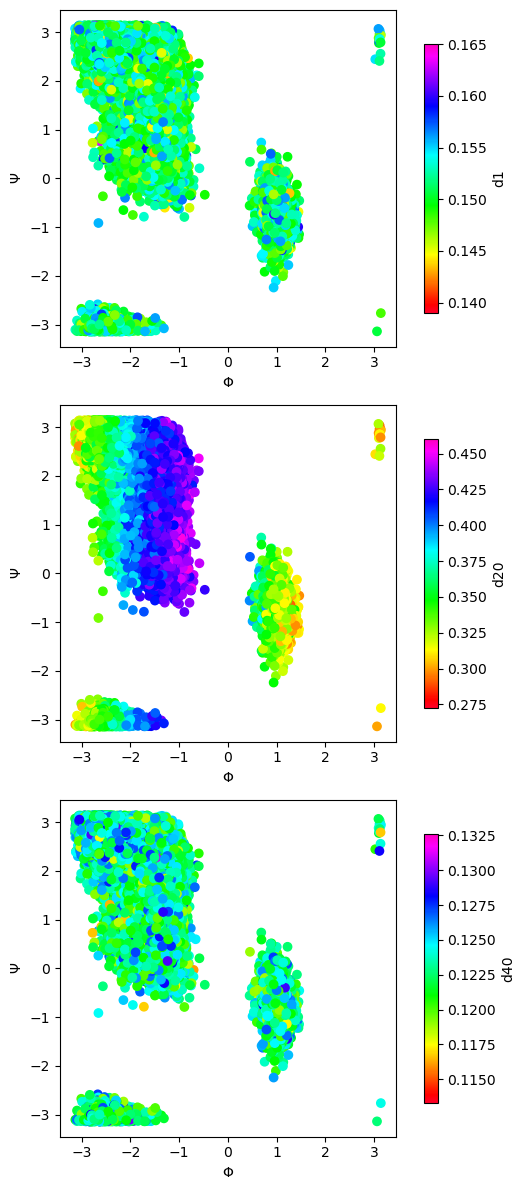

In [39]:
features = ["d1", "d20", "d40"]

fig, ax = plt.subplots(len(features), 1, figsize=(6, len(features) * 4))

for i in range(len(features)):
    handle = ax[i].scatter(df["phi"], df["psi"], c=df[features[i]], cmap=plt.cm.gist_rainbow)
    plt.colorbar(handle, ax=ax[i], label=features[i], shrink=0.8)

    ax[i].set_xlabel(r"$\Phi$")
    ax[i].set_ylabel(r"$\Psi$")
    ax[i].set_aspect('equal')

plt.tight_layout()

Extract only the distances from the data:

In [40]:
X = df.filter(regex=("^d"))

In [41]:
X.shape

(100001, 45)

In [42]:
X

,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,...,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45
0,0.151452,0.237371,0.241628,0.383889,0.438788,0.474394,0.593105,0.449286,0.574327,0.122825,...,0.260934,0.305422,0.366489,0.501006,0.121898,0.136494,0.250460,0.227093,0.286349,0.147188
1,0.145782,0.232463,0.236251,0.380054,0.461041,0.462359,0.579530,0.443853,0.567384,0.121810,...,0.257523,0.315515,0.347293,0.479157,0.123973,0.134938,0.251096,0.225544,0.284159,0.148281
2,0.149086,0.234911,0.242539,0.385714,0.469854,0.458700,0.558051,0.457928,0.567240,0.119819,...,0.255473,0.338352,0.313939,0.450488,0.124880,0.131097,0.246643,0.224512,0.283784,0.146184
3,0.148510,0.229417,0.243333,0.384160,0.450256,0.454465,0.541487,0.463439,0.593971,0.121873,...,0.252170,0.340675,0.311837,0.434864,0.121096,0.133588,0.244186,0.221912,0.277109,0.145273
4,0.152158,0.239642,0.243398,0.383222,0.466896,0.463687,0.574880,0.444740,0.557232,0.121661,...,0.251922,0.321590,0.334942,0.470411,0.122082,0.137745,0.248524,0.224815,0.276933,0.146423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,0.153057,0.239632,0.247946,0.380080,0.468442,0.455983,0.542934,0.464261,0.580532,0.120793,...,0.272386,0.315935,0.383613,0.508001,0.123420,0.131220,0.240852,0.219504,0.271484,0.141353
99997,0.148606,0.227268,0.249542,0.381025,0.482689,0.452778,0.526530,0.470346,0.573227,0.124124,...,0.260634,0.292557,0.380055,0.511719,0.125808,0.135531,0.254852,0.228551,0.297417,0.144129
99998,0.152255,0.239520,0.248578,0.384120,0.485045,0.448545,0.548142,0.441213,0.548454,0.126508,...,0.252325,0.281011,0.370508,0.489832,0.127194,0.130361,0.238674,0.224148,0.275099,0.139155
99999,0.156591,0.245586,0.248929,0.390534,0.487549,0.452313,0.551071,0.440168,0.540194,0.125717,...,0.253759,0.273313,0.372044,0.498764,0.128671,0.132500,0.245185,0.234889,0.292515,0.146569


Let's first try with principal component analysis:

<img src="https://numxl.com/wp-content/uploads/principal-component-analysis-pca-featured.png" width="600" style="margin-left:auto; margin-right:auto"/>

In [43]:
stride = 10

X_train = X.values[::stride]

In [44]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
Z = pca.fit_transform(X_train)

Several first PCA coordinates carry some physical information:

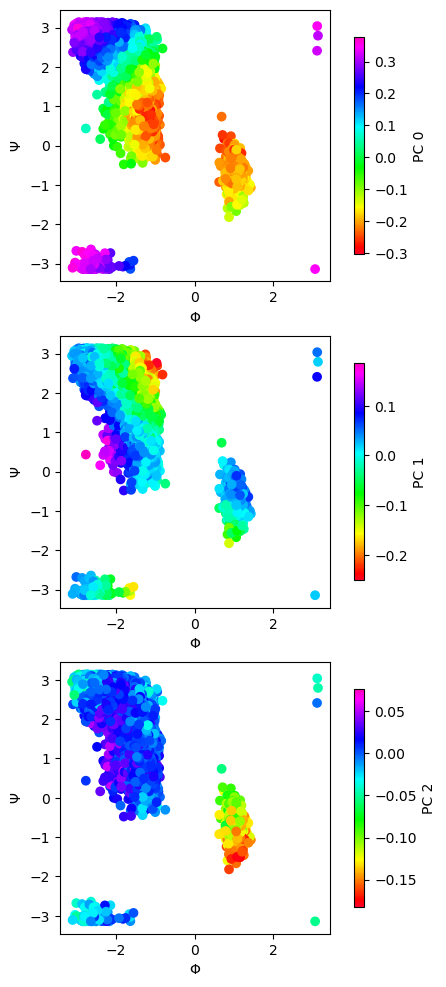

In [45]:
n_pc = 3

fig, ax = plt.subplots(len(features), 1, figsize=(6, n_pc * 4))

for i in range(n_pc):
    handle = ax[i].scatter(df["phi"].values[::stride], df["psi"].values[::stride], c=Z[:,i], cmap=plt.cm.gist_rainbow)
    plt.colorbar(handle, ax=ax[i], label=f"PC {i}", shrink=0.8)

    ax[i].set_xlabel(r"$\Phi$")
    ax[i].set_ylabel(r"$\Psi$")
    ax[i].set_aspect('equal')

Importance of each PCA coordinate:

Text(0, 0.5, 'Explained variance')

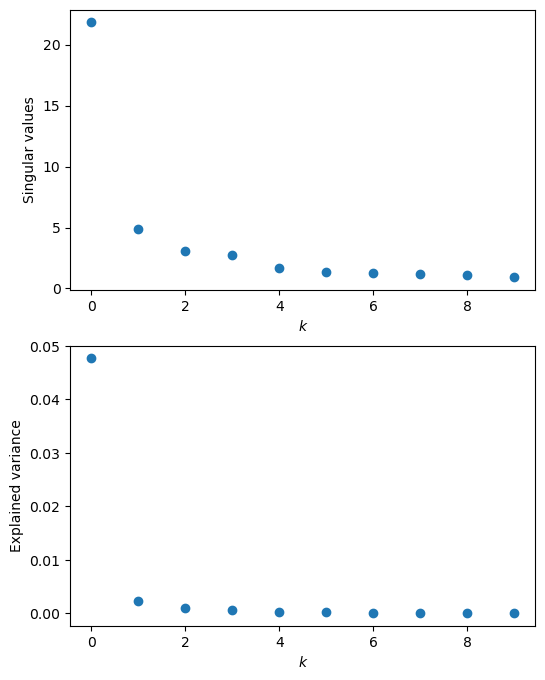

In [46]:
fig, ax = plt.subplots(2, 1, figsize=(6, 2 * 4))


ax[0].scatter(range(pca.singular_values_.shape[0]), pca.singular_values_)
ax[0].set_xlabel(r"$k$")
ax[0].set_ylabel(r"Singular values")

ax[1].scatter(range(pca.explained_variance_.shape[0]), pca.explained_variance_)
ax[1].set_xlabel(r"$k$")
ax[1].set_ylabel(r"Explained variance")

How the PCA space looks?

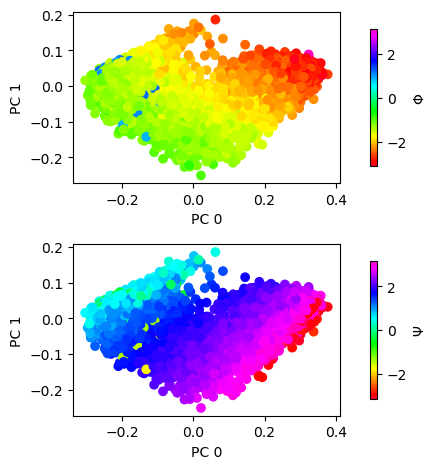

In [47]:
fig, ax = plt.subplots(2, 1)

handle = ax[0].scatter(Z[:,0], Z[:,1], c=df["phi"].values[::stride], cmap=plt.cm.gist_rainbow)
plt.colorbar(handle, ax=ax[0], label=r"$\Phi$", shrink=0.8)

ax[0].set_xlabel(r"PC 0")
ax[0].set_ylabel(r"PC 1")
ax[0].set_aspect('equal')

handle = ax[1].scatter(Z[:,0], Z[:,1], c=df["psi"].values[::stride], cmap=plt.cm.gist_rainbow)
plt.colorbar(handle, ax=ax[1], label=r"$\Psi$", shrink=0.8)

ax[1].set_xlabel(r"PC 0")
ax[1].set_ylabel(r"PC 1")
ax[1].set_aspect('equal')

plt.tight_layout()

... But the density shows that only two big states are found by PCA:

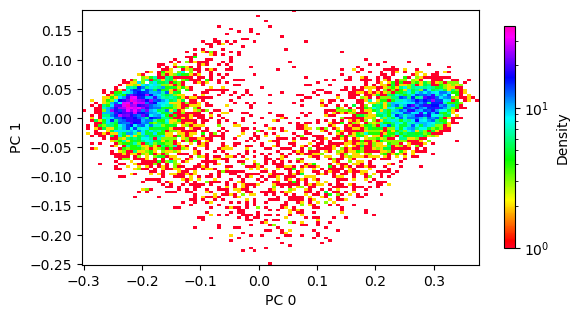

In [48]:
fig, ax = plt.subplots(1, 1)

handle = ax.hist2d(Z[:,0], Z[:,1], bins=100, cmap=plt.cm.gist_rainbow, norm=matplotlib.colors.LogNorm());
plt.colorbar(handle[-1], ax=ax, label="Density", shrink=0.6)

ax.set_xlabel(r"PC 0")
ax.set_ylabel(r"PC 1")
ax.set_aspect('equal')

Let's try another ML method frequently used for dimensionality reduction:

<img src="https://nlml.github.io/images/tsne/tsne-mnist.png" width="600" style="margin-left:auto; margin-right:auto"/>

Finding right perplexity is a hurdle:

In [49]:
from sklearn.manifold import TSNE

Z = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X_train)

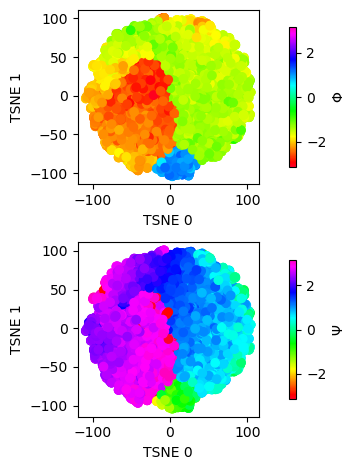

In [50]:
fig, ax = plt.subplots(2, 1)

handle = ax[0].scatter(Z[:,0], Z[:,1], c=df["phi"].values[::stride], cmap=plt.cm.gist_rainbow)
plt.colorbar(handle, ax=ax[0], label=r"$\Phi$", shrink=0.8)

ax[0].set_xlabel(r"TSNE 0")
ax[0].set_ylabel(r"TSNE 1")
ax[0].set_aspect('equal')

handle = ax[1].scatter(Z[:,0], Z[:,1], c=df["psi"].values[::stride], cmap=plt.cm.gist_rainbow)
plt.colorbar(handle, ax=ax[1], label=r"$\Psi$", shrink=0.8)

ax[1].set_xlabel(r"TSNE 0")
ax[1].set_ylabel(r"TSNE 1")
ax[1].set_aspect('equal')

plt.tight_layout()

Let's consider a method specifically devised to find slow reaction coordinates -- time-lagged independent component analysis:

In [ ]:
!pip install deeptime

In [51]:
from deeptime.decomposition import TICA

In [52]:
tica = TICA(lagtime=2)

covariances = TICA.covariance_estimator(lagtime=2).fit(X_train)
tica.fit(covariances)

TICA-4506799904:[{'dim': None,
                 'epsilon': 1e-06,
                 'lagtime': 2,
                 'observable_transform': <deeptime.basis._monomials.Identity object at 0x10c635910>,
                 'scaling': 'kinetic_map',
                 'var_cutoff': None}]

In [53]:
model = tica.fetch_model()
Z = model.transform(X_train)

All important states found:

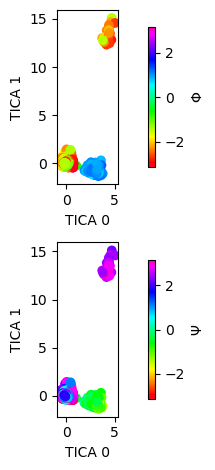

In [54]:
fig, ax = plt.subplots(2, 1)

handle = ax[0].scatter(Z[:,0], Z[:,1], c=df["phi"].values[::stride], cmap=plt.cm.gist_rainbow)
plt.colorbar(handle, ax=ax[0], label=r"$\Phi$", shrink=0.8)

ax[0].set_xlabel(r"TICA 0")
ax[0].set_ylabel(r"TICA 1")
ax[0].set_aspect('equal')

handle = ax[1].scatter(Z[:,0], Z[:,1], c=df["psi"].values[::stride], cmap=plt.cm.gist_rainbow)
plt.colorbar(handle, ax=ax[1], label=r"$\Psi$", shrink=0.8)

ax[1].set_xlabel(r"TICA 0")
ax[1].set_ylabel(r"TICA 1")
ax[1].set_aspect('equal')

plt.tight_layout()

Density:

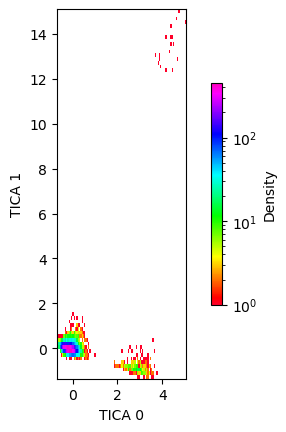

In [55]:
fig, ax = plt.subplots(1, 1)

handle = ax.hist2d(Z[:,0], Z[:,1], bins=100, cmap=plt.cm.gist_rainbow, norm=matplotlib.colors.LogNorm());
plt.colorbar(handle[-1], ax=ax, label="Density", shrink=0.6)

ax.set_xlabel(r"TICA 0")
ax.set_ylabel(r"TICA 1")
ax.set_aspect('equal')

How to determine the lag time?

In [56]:
from deeptime.util.validation import implied_timescales, ck_test
from deeptime.plots import plot_implied_timescales, plot_ck_test

lagtimes = np.arange(1, 10, dtype=np.int32)
tica_models = [TICA(lagtime=lag).fit_fetch(X_train) for lag in lagtimes]

Implied timescale test:

Text(0, 0.5, 'timescale')

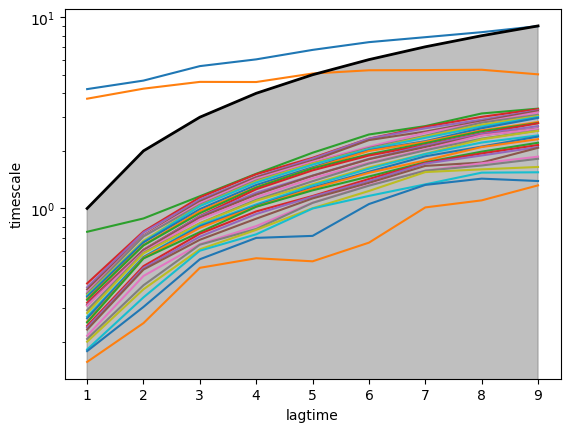

In [57]:
ax = plot_implied_timescales(implied_timescales(tica_models))
ax.set_yscale('log')
ax.set_xlabel('lagtime')
ax.set_ylabel('timescale')

Having slow coordinates, we can try to extract kinetic information by constructing a Markov state model:

For this, we need to first cluster the data into microstates:

In [58]:
from deeptime.clustering import KMeans

clustering = KMeans(n_clusters=100).fit_fetch(Z)

dtrajs = clustering.transform(Z)

In [59]:
dtrajs

array([16,  2, 82, ..., 55, 91,  4], dtype=int32)

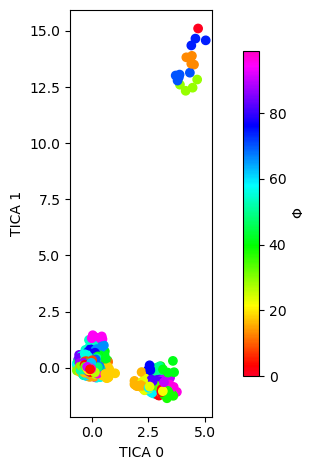

In [60]:
fig, ax = plt.subplots(1, 1)

handle = ax.scatter(Z[:,0], Z[:,1], c=dtrajs, cmap=plt.cm.gist_rainbow)
plt.colorbar(handle, ax=ax, label=r"$\Phi$", shrink=0.8)

ax.set_xlabel(r"TICA 0")
ax.set_ylabel(r"TICA 1")
ax.set_aspect('equal')

plt.tight_layout()

Now we use this clustering to construct an MSM:

In [61]:
import deeptime.markov as markov

estimator = markov.msm.MaximumLikelihoodMSM(
    reversible=True,
)

counts_estimator = markov.TransitionCountEstimator(
    lagtime=2, count_mode="sliding"
)
counts = counts_estimator.fit(dtrajs).fetch_model()

msm = estimator.fit(counts).fetch_model()

The transition matrix for microstates is not really helpful in visual analysis:

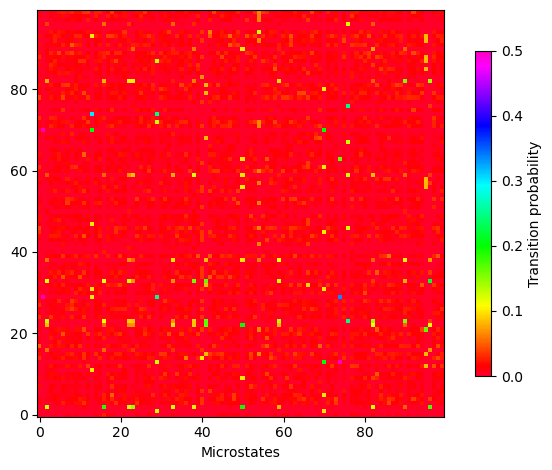

In [62]:
fig, ax = plt.subplots(1, 1)

handle = ax.imshow(msm.transition_matrix.T, origin='lower', cmap=plt.cm.gist_rainbow)
plt.colorbar(handle, ax=ax, label=r"Transition probability", shrink=0.8)

ax.set_xlabel(r"Microstates")
ax.set_aspect('equal')

plt.tight_layout()

Let's coarse-grain the microscates into macrostates using Perron cluster-cluster analysis (PCCA):

In [63]:
pcca = msm.pcca(n_metastable_sets=3)
coarse_states = pcca.assignments[dtrajs]

The result is perfect:

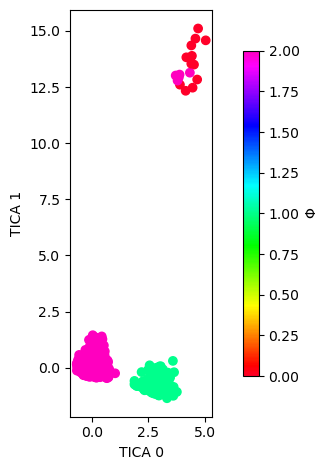

In [64]:
fig, ax = plt.subplots(1, 1)

handle = ax.scatter(Z[:,0], Z[:,1], c=coarse_states, cmap=plt.cm.gist_rainbow)
plt.colorbar(handle, ax=ax, label=r"$\Phi$", shrink=0.8)

ax.set_xlabel(r"TICA 0")
ax.set_ylabel(r"TICA 1")
ax.set_aspect('equal')

plt.tight_layout()

Transition matrix:

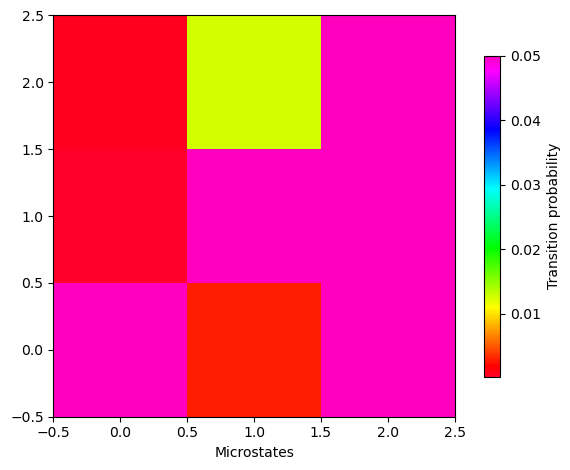

In [65]:
fig, ax = plt.subplots(1, 1)

handle = ax.imshow(pcca.coarse_grained_transition_matrix, origin='lower', cmap=plt.cm.gist_rainbow, vmax=0.05)
plt.colorbar(handle, ax=ax, label=r"Transition probability", shrink=0.8)

ax.set_xlabel(r"Microstates")
ax.set_aspect('equal')

plt.tight_layout()

And finally let's see some kinetic information. Mean first-passage times:

In [66]:
from itertools import product

nstates = 3
mfpt = np.zeros((nstates, nstates))
for i, j in product(range(nstates), repeat=2):
    mfpt[i, j] = msm.mfpt(
        pcca.sets[i],
        pcca.sets[j])

print(np.round(mfpt / 1000.0, decimals=2))

[[0.   0.2  0.01]
 [4.52 0.   0.01]
 [4.52 0.19 0.  ]]


Many other methods:

For instance, spectral map:

<img src="https://github.com/jakryd/bit25-workshop/blob/main/fig/fig-outline.png?raw=true" width="1000" style="margin-left:auto; margin-right:auto"/>

Example on chignolin data:

<img src="https://github.com/jakryd/bit25-workshop/blob/main/fig/fig-cln.png?raw=true" width="1000" style="margin-left:auto; margin-right:auto"/>

Take home message:
- Feature design is very important and system-dependent.
- Many unsupervised ML methods, not every designed for MD.
- Reaction coordinates have special properties that the used ML method should account for.

Our recent review:

- T Gökdemir, J Rydzewski, Chemical Physics Reviews 6 (1), 2025; 